### IMPORT STUFF HERE

pip install geopy

In [1]:
%%time
# Importing all the necessary libraries for this project.

import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import datetime
import datetime as dt
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import statsmodels.api as sm
from sklearn import metrics
from bs4 import BeautifulSoup
import requests
import time
from selenium import webdriver
import re
from selenium.webdriver.common.keys import Keys
from uuid import uuid4 as uuid
from datetime import datetime 
from pygeocoder import Geocoder
from time import sleep


/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


CPU times: user 1.61 s, sys: 539 ms, total: 2.15 s
Wall time: 2.87 s


### IMPORT ALL THE RELEVANT FILES. MAKE SURE YOUR NAMES ARE THE SAME HERE

In [2]:
wnv_data = pd.read_csv("train.csv", error_bad_lines=False, low_memory=False)
test = pd.read_csv("test.csv", error_bad_lines=False, low_memory=False)


wnv_spray = pd.read_csv("spray.csv", error_bad_lines=False, low_memory=False)

wnv_weather = pd.read_csv("weather.csv", error_bad_lines=False, low_memory=False)

census_info = pd.read_csv("census_info.csv", error_bad_lines=False, low_memory=False)

census_age = pd.read_csv("census_age.csv", error_bad_lines=False, low_memory=False)

cols = ['2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016']
robin= pd.DataFrame([[7502,6923,6543,6123,6915,7003,7907,7343,7385,6814,6341,6538]],columns=cols)

### FIX CENSUS_INFO columns & dtypes

In [3]:
census_info = census_info.drop(["GEO.id", "GEO.display-label", "Unnamed: 0"], axis = 1)
census_info["zip_code"] = census_info["zip_code"].astype(str)

census_age = census_age.drop(["GEO.id", "GEO.display-label", "Unnamed: 0"], axis = 1)
census_age["zip_code"] = census_age["zip_code"].astype(str)

pd.set_option('display.max_columns', None)


In [4]:
def zip_code(x):
    if "60" in x.split()[-2]:
        zipcode = x.split()[-2].replace(",", "")
    elif "South Doty Avenue, Chicago, IL, USA" in x:
        zipcode = "60633"
    elif "South Stony Island Avenue, Chicago, IL, USA" in x:
        zipcode = "60617"
    elif "South Torrence Avenue, Chicago, IL, USA" in x:
        zipcode = "60617"
    elif "South Cottage Grove Avenue, Chicago, IL, USA" in x:
        zipcode = "60619"
    elif "South Vincennes Avenue, Chicago, IL, USA" in x:
        zipcode = "60620"
    elif "East 91st Place, Chicago, IL, USA" in x:
        zipcode = "60619"
    elif "West Garfield Boulevard, Chicago, IL, USA" in x:
        zipcode = "60636"
    elif "6400 West Strong Street, Chicago, IL, USA" in x:
        zipcode = "60630"
    elif "East 91st Street, Chicago, IL, USA" in x:
        zipcode = "60617"
    elif "West 37th Place, Chicago, IL, USA" in x:
        zipcode = "60609"
    elif "South Wallace Street, Chicago, IL, USA" in x:
        zipcode = "60620"
    elif x == "Chicago, IL, USA":
        zipcode = "60613"
    else:
        zipcode = "00000"
    
    return(zipcode)

def fix_date(x):
    fix_date = datetime.strptime(x, "%Y-%m-%d")
    return(fix_date)

def fix_chars(x):
    try:
        return(float(x))
    except:
        return None

### FIX DATE, ZIPCODE HERE

In [5]:
wnv_data["Date"] = wnv_data["Date"].apply(fix_date)

In [6]:
wnv_data["ZipCode"] = wnv_data["Address"].apply(zip_code)

In [7]:
wnv_data[wnv_data["ZipCode"]=="00000"]["AddressNumberAndStreet"].value_counts()

Series([], Name: AddressNumberAndStreet, dtype: int64)

In [8]:
census_age = census_age.replace("-", 0)

census_age.zip_code = census_age.zip_code.astype(object)
census_age.total_population = census_age.total_population.astype(int)

In [9]:
census_age.head()

,zip_code,total_population,percent_age_under_5,percent_age_5-9,percent_age_10-14,percent_age_15-19,percent_age_20-24,percent_age_25-34,percent_age_35-44,percent_age_45-54,percent_age_55-59,percent_age_60-64,percent_age_65-74,percent_age_75-84,percent_age85_and_over,percent_age_65_and_over,median_age
0,60002,24250,5.7,7.2,6.4,7.9,4.7,9.9,14.2,17.3,8.1,6.5,8.2,2.8,1,12,41.2
1,60004,49957,5.5,6.5,6,6.3,4.8,11.8,13.1,16.1,6.4,6.5,8.9,5.6,2.6,17.1,41.8
2,60005,30931,7,5.1,7.3,6.1,4.4,13.5,14.9,14.8,4.9,5.9,7.5,5.2,3.4,16,39.8
3,60007,33973,4.6,4.9,6.5,6.3,5.7,11.3,12.9,18.4,7.6,6.9,7.7,5.4,1.8,14.9,43.5
4,60008,22302,8.1,6.2,5.2,6,5.8,16.6,13,14.9,6.4,4.9,6.2,4.5,2,12.8,36.2


#### MERGE WNV + CENSUS = WNV_POP. THEN MERGE WNV_POP + CENSUS_AGE = WNV_POP_AGE. THEN MERGE MERGE WNV_POP_AGE + SPRAY = WNV_SPRAY

In [10]:
wnv_pop = pd.merge(wnv_data, census_info, how = "left", left_on=["ZipCode"], right_on=["zip_code"])
wnv_pop = wnv_pop.drop("zip_code", axis = 1)

In [11]:
wnv_pop_age = pd.merge(wnv_pop, census_age, how = "left", left_on=["ZipCode"], right_on=["zip_code"])
wnv_pop_age = wnv_pop_age.drop("zip_code", axis = 1)

In [13]:
wnv_pop_age["Month"] = (wnv_pop_age["Date"].dt.month)
wnv_pop_age["Week"] = (wnv_pop_age["Date"].dt.week)
wnv_pop_age["Year"] = (wnv_pop_age["Date"].dt.year)

In [16]:
wnv_spray["Date"] = wnv_spray["Date"].apply(fix_date)
wnv_spray["Year"] = (wnv_spray["Date"].dt.year)

In [17]:
wnv_pop_age.to_csv('WNV_Pop_Age.csv', header=True)

In [18]:
# It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. 
#We provide you with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests. 
#Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
#Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

wnv_temp = wnv_weather.iloc[:,0:5]
wnv_temp["Date"] = wnv_temp["Date"].apply(fix_date)


wnv_temp["Month"] = (wnv_temp["Date"].dt.month)
wnv_temp["Week"] = (wnv_temp["Date"].dt.week)
wnv_temp["Year"] = (wnv_temp["Date"].dt.year)
wnv_temp["Tavg"] = wnv_temp["Tavg"].apply(fix_chars)

wnv_tempavg = pd.DataFrame(round(wnv_temp.groupby(["Year", "Month", "Week"], as_index=False)["Tavg"].mean(),2))

In [19]:
wnv_pop_age_temp = pd.merge(wnv_pop_age,wnv_tempavg, how = "left", on = ["Year", "Month", "Week"])

In [20]:
wnv_pop_age_temp.to_csv('WNV_Pop_Age_Temp.csv', header=True)

In [21]:
## WATER AREA & LAND AREA FROM CITY-DATA

zipcode = []
water_area = []
land_area = []
URL = "http://www.city-data.com/zipmaps/Chicago-Illinois.html"

citydata_request = requests.get(URL)
soup = BeautifulSoup(citydata_request.text, "lxml")

def extract_info(soup):
    for posts in soup.find_all(class_="zip data-block"):
        zipcode.append(posts.strong.text.split()[2])
        
        water_area_1 = fix_chars(posts.text.split()[51])
        water_area_2 = fix_chars(posts.text.split()[50])
        
        if water_area_2 is None:
            water_area.append(water_area_1)
        else:
            water_area.append(water_area_2)
            
            
            
        land_area_1 = fix_chars(posts.text.split()[46])
        land_area_2 = fix_chars(posts.text.split()[45])
        
        if land_area_2 is None:
            land_area.append(land_area_1)
        else:
            land_area.append(land_area_2)

extract_info(soup)                
        
chicago_geog = pd.DataFrame({"ZipCode" : zipcode, "WaterArea": water_area, "LandArea": land_area})    


In [22]:
wnv_pop_age_temp_geog = pd.merge(wnv_pop_age_temp, chicago_geog, on = "ZipCode", how = "left")
wnv_pop_age_temp_geog.to_csv('WNV_Pop_Age_Temp_Geog.csv', header=True)

In [23]:
wnv_pop_age_temp_geog

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,ZipCode,poulation,percent_employed,inc_<10k,inc_10-15k,inc_15-25k,median_inc,mean_inc,percent_no_health,percent_public_health,total_population,percent_age_under_5,percent_age_5-9,percent_age_10-14,percent_age_15-19,percent_age_20-24,percent_age_25-34,percent_age_35-44,percent_age_45-54,percent_age_55-59,percent_age_60-64,percent_age_65-74,percent_age_75-84,percent_age85_and_over,percent_age_65_and_over,median_age,Month,Week,Year,Tavg,LandArea,WaterArea
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,60634,59366.0,68,6.4,4.1,10.1,55767,66516,21.9,29.9,72718.0,6.1,5.8,5.3,6,6.1,16.4,13.1,14.2,7.6,6.6,6.7,4.2,1.9,12.8,38.9,5,22,2007,73.00,7.1,0.0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,60634,59366.0,68,6.4,4.1,10.1,55767,66516,21.9,29.9,72718.0,6.1,5.8,5.3,6,6.1,16.4,13.1,14.2,7.6,6.6,6.7,4.2,1.9,12.8,38.9,5,22,2007,73.00,7.1,0.0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,60646,22309.0,63.2,5.3,5.1,8.6,75419,103350,10.7,26.5,28314.0,7.5,6.8,5.7,4.7,4.7,10.4,12.8,14.3,7.1,6.1,9.1,6.3,4.5,19.8,42.7,5,22,2007,73.00,4.6,0.0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,60656,22401.0,67.4,5.3,4.5,12.1,54134,68564,15.7,28.3,27468.0,6.9,5.9,5,2.8,4.9,15.3,15,14.5,7.3,6.3,8.7,4.7,2.7,16.1,41.1,5,22,2007,73.00,3.3,0.0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,60656,22401.0,67.4,5.3,4.5,12.1,54134,68564,15.7,28.3,27468.0,6.9,5.9,5,2.8,4.9,15.3,15,14.5,7.3,6.3,8.7,4.7,2.7,16.1,41.1,5,22,2007,73.00,3.3,0.0
5,2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",CULEX RESTUANS,15,W WEBSTER AVE,T045,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,2,0,60614,59408.0,78,8.4,3.7,5.7,86215,134437,6,10.5,68363.0,5.8,3.8,2.9,5,13.6,31.2,13.2,8.7,3.9,3.8,5,2.1,1.1,8.2,29.8,5,22,2007,73.00,3.2,0.3
6,2007-05-29,"2500 West Grand Avenue, Chicago, IL 60654, USA",CULEX RESTUANS,25,W GRAND AVE,T046,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,1,0,60654,15004.0,85.5,8.5,3.7,3.6,90645,149346,7.9,6.5,15885.0,3.8,0.7,1,0.9,8.2,40.8,20.4,10.8,5.5,4.1,2.3,1.1,0.3,3.7,32.8,5,22,2007,73.00,0.6,0.0
7,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,1,0,60608,63425.0,60.9,11.8,7.7,16.3,35336,48667,29.5,36.1,78794.0,6.4,6.2,5.8,7.1,10.1,21.2,14.3,11.7,5.2,4.2,3.9,2.7,1.1,7.8,31.3,5,22,2007,73.00,6.4,0.2
8,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2,0,60608,63425.0,60.9,11.8,7.7,16.3,35336,48667,29.5,36.1,78794.0,6.4,6.2,5.8,7.1,10.1,21.2,14.3,11.7,5.2,4.2,3.9,2.7,1.1,7.8,31.3,5,22,2007,73.00,6.4,0.2
9,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,1,0,60642,16555.0,80.8,8.1,2.7,9,67591,89573,15.3,14.6,18312.0,4.9,2.2,2.1,2.3,10.5,39.1,17.7,9,2.6,2.7,4.8,1.4,0.7,6.9,31.7,5,22,2007,73.00,NaN,NaN


In [24]:
def create_map(X, locations):

    mapdata = np.loadtxt("mapdata_copyright_openstreetmap_contributors.txt")
    alpha_cm = plt.cm.Reds
    alpha_cm._init()
    alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
    aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
    lon_lat_box = (-88, -87.5, 41.6, 42.1)

    kd = KernelDensity(bandwidth=0.02)
    kd.fit(X)

    xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(),yv.ravel()]).T
    zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
    plt.figure(figsize=(10,20), dpi = 100)
    plt.imshow(mapdata, 
               cmap=plt.get_cmap('gray'), 
               extent=lon_lat_box, 
               aspect=aspect)
    plt.imshow(zv, 
               origin='lower', 
               cmap=alpha_cm, 
               extent=lon_lat_box, 
               aspect=aspect)
    
    
    # THIS PLOTS THE TRAPS LOCATIONS
    plt.scatter(locations[:,0], locations[:,1], marker='o', color = "black")

    plt.savefig('heatmap.png')
    
    plt.show()

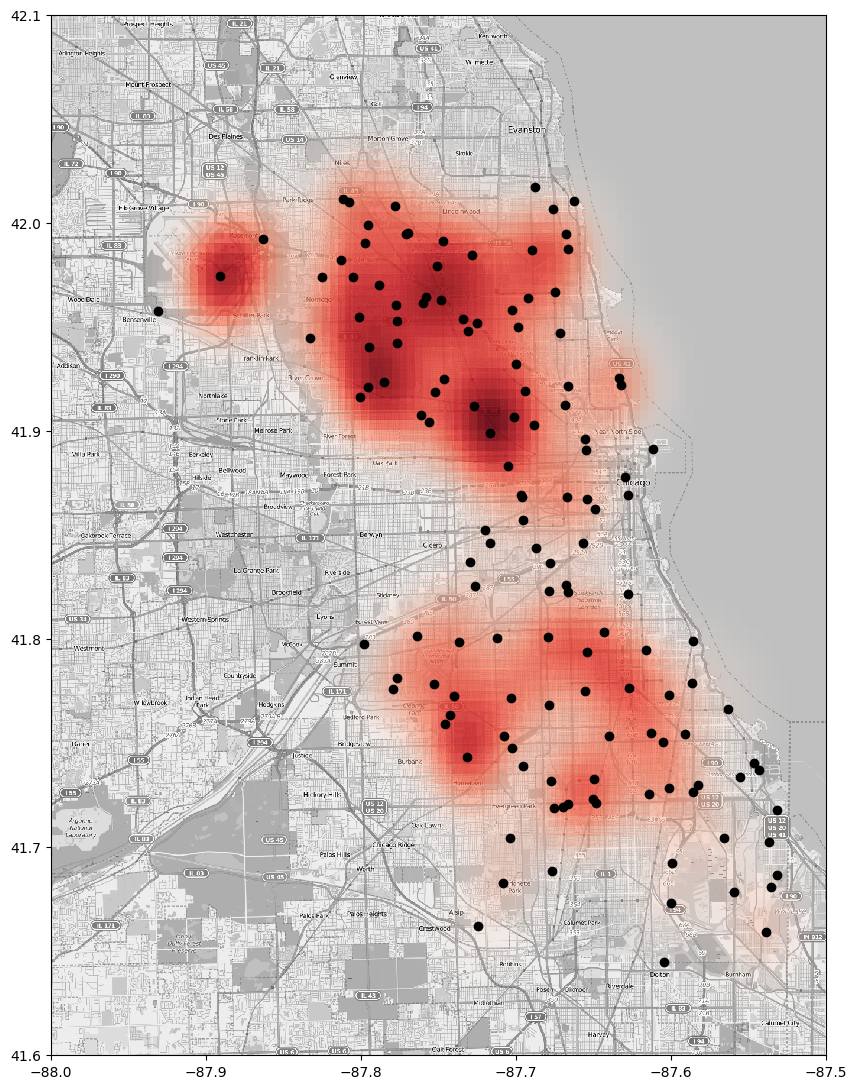

In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#%matplotlib inline

from sklearn.neighbors import KernelDensity

## X = WHAT WE ARE TRYING TO PLOT
## LOCATIONS = 


sightings = wnv_pop_age_temp_geog[(wnv_pop_age_temp_geog['WnvPresent'] > 0) & (wnv_pop_age_temp_geog["Year"]==2013)]
sightings_temp = sightings.groupby(['Date', 'Trap','Longitude', 'Latitude']).nunique()['WnvPresent'].reset_index()
X = sightings_temp[['Longitude', 'Latitude']].values
locations = wnv_pop_age_temp_geog[['Longitude', 'Latitude']].drop_duplicates().values

create_map(X, locations)

In [26]:
def spray_map(X, locations):

    mapdata = np.loadtxt("mapdata_copyright_openstreetmap_contributors.txt")
    alpha_cm = plt.cm.Blues
    alpha_cm._init()
    alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
    aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
    lon_lat_box = (-88, -87.5, 41.6, 42.1)

    kd = KernelDensity(bandwidth=0.02)
    kd.fit(X)

    xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(),yv.ravel()]).T
    zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
    plt.figure(figsize=(10,20), dpi = 100)
    plt.imshow(mapdata, 
               cmap=plt.get_cmap('gray'), 
               extent=lon_lat_box, 
               aspect=aspect)
    plt.imshow(zv, 
               origin='lower', 
               cmap=alpha_cm, 
               extent=lon_lat_box, 
               aspect=aspect)
    
    
    # THIS PLOTS THE TRAPS LOCATIONS
    plt.scatter(locations[:,0], locations[:,1], marker='o', color = "blue")

    plt.savefig('spraymap.png')
    
    plt.show()

In [27]:
wnv_spray["Count"] = "1"

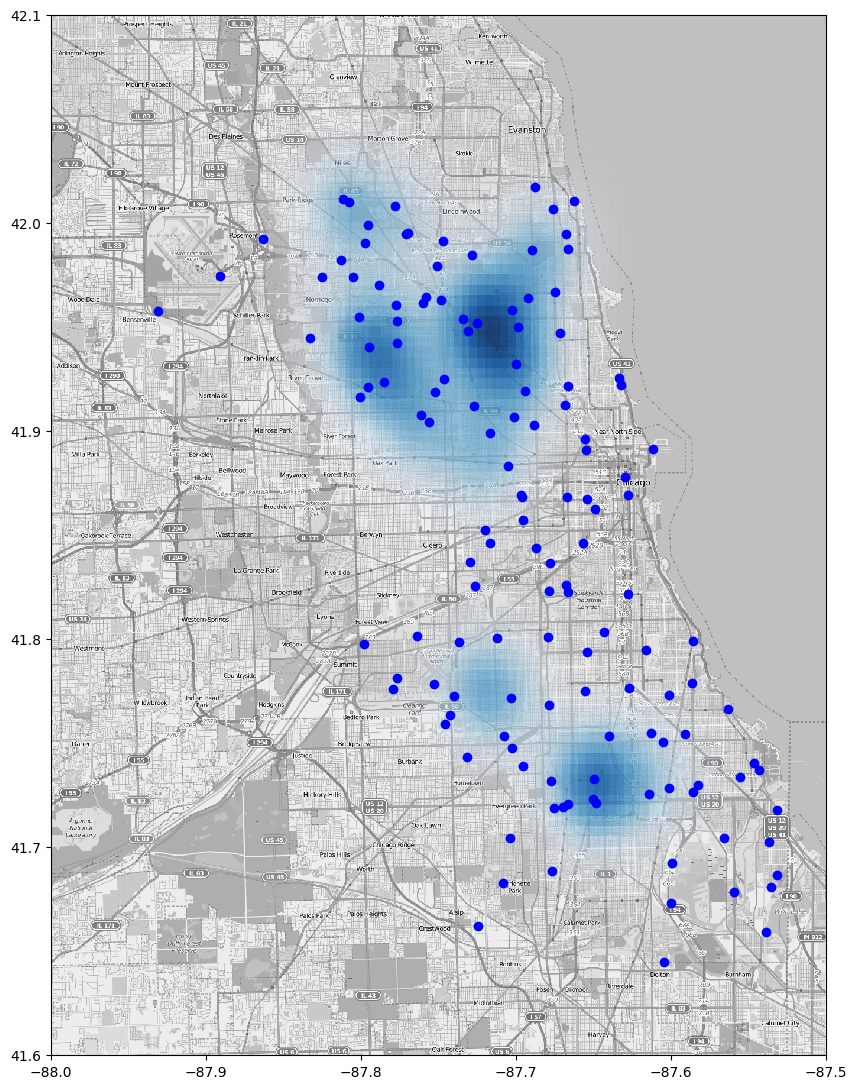

In [28]:
spray_2013 = wnv_spray[wnv_spray["Date"].dt.year==2013]
spray_temp = spray_2013.groupby(["Date", "Latitude", "Longitude"]).max()["Count"].reset_index()
spray_X = spray_temp[['Longitude', 'Latitude']].values
locations = wnv_pop_age_temp_geog[['Longitude', 'Latitude']].drop_duplicates().values

spray_map(spray_X, locations)

In [29]:
wnv_spray.head(5)

,Date,Time,Latitude,Longitude,Year,Count
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,2011,1
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,2011,1
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,2011,1
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,2011,1
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,2011,1


In [30]:
spray_2013[spray_2013["Longitude"]>-87.65].shape

(1582, 6)

In [31]:
sightings_temp

,Date,Trap,Longitude,Latitude,WnvPresent
0,2013-06-28,T094,-87.666014,41.720848,1
1,2013-07-12,T008,-87.777921,42.008314,1
2,2013-07-12,T073,-87.600880,41.773215,1
3,2013-07-12,T158,-87.707973,41.682587,1
4,2013-07-12,T159,-87.649642,41.732984,1
5,2013-07-12,T228,-87.725057,41.951866,1
6,2013-07-12,T231,-87.666066,41.987280,1
7,2013-07-19,T003,-87.757639,41.964242,1
8,2013-07-19,T008,-87.777921,42.008314,1
9,2013-07-19,T013,-87.785288,41.923738,1


In [32]:
col_names = census_age.iloc[:, 2:].columns
for col in col_names:
    census_age[col] = census_age[col].astype(float, copy = False)

In [33]:
census_age

,zip_code,total_population,percent_age_under_5,percent_age_5-9,percent_age_10-14,percent_age_15-19,percent_age_20-24,percent_age_25-34,percent_age_35-44,percent_age_45-54,percent_age_55-59,percent_age_60-64,percent_age_65-74,percent_age_75-84,percent_age85_and_over,percent_age_65_and_over,median_age
0,60002,24250,5.7,7.2,6.4,7.9,4.7,9.9,14.2,17.3,8.1,6.5,8.2,2.8,1.0,12.0,41.2
1,60004,49957,5.5,6.5,6.0,6.3,4.8,11.8,13.1,16.1,6.4,6.5,8.9,5.6,2.6,17.1,41.8
2,60005,30931,7.0,5.1,7.3,6.1,4.4,13.5,14.9,14.8,4.9,5.9,7.5,5.2,3.4,16.0,39.8
3,60007,33973,4.6,4.9,6.5,6.3,5.7,11.3,12.9,18.4,7.6,6.9,7.7,5.4,1.8,14.9,43.5
4,60008,22302,8.1,6.2,5.2,6.0,5.8,16.6,13.0,14.9,6.4,4.9,6.2,4.5,2.0,12.8,36.2
5,60010,44031,4.7,6.1,8.1,7.6,3.8,5.9,11.3,19.2,8.3,7.1,10.9,5.3,1.8,17.9,46.3
6,60012,11081,3.4,5.9,10.4,9.3,5.1,5.2,12.5,21.5,9.4,6.7,5.9,3.3,1.3,10.6,43.6
7,60013,26811,5.9,7.3,8.0,8.7,5.6,9.4,12.3,22.2,7.1,5.9,4.8,2.1,0.7,7.6,39.4
8,60014,48234,6.0,7.1,8.1,9.1,5.0,11.6,14.4,16.0,6.6,5.0,6.4,2.9,1.8,11.0,37.4
9,60015,27218,5.5,6.8,8.6,8.7,4.4,6.8,13.1,16.1,7.7,7.2,9.1,3.6,2.2,15.0,42.3


In [34]:
census_age["HighRisk%"] = census_age["percent_age_65_and_over"]
census_age["LowRisk%"] = 100-census_age["HighRisk%"]

census_age["HighRiskTotal"] = (census_age["HighRisk%"]*census_age["total_population"]/100).astype(int)
census_age["LowRiskTotal"] = (census_age["LowRisk%"]*census_age["total_population"]/100).astype(int)

In [35]:
chicago_zips = wnv_data["ZipCode"].drop_duplicates().reset_index()

census_chicago = pd.merge(chicago_zips, census_age, left_on = "ZipCode", right_on='zip_code', how = 'left')

high_risktotal = census_chicago["HighRiskTotal"].sum(axis = 0)
low_risktotal = census_chicago["LowRiskTotal"].sum()


In [36]:
census_chicago.sort_values("percent_age_65_and_over")

,index,ZipCode,zip_code,total_population,percent_age_under_5,percent_age_5-9,percent_age_10-14,percent_age_15-19,percent_age_20-24,percent_age_25-34,percent_age_35-44,percent_age_45-54,percent_age_55-59,percent_age_60-64,percent_age_65-74,percent_age_75-84,percent_age85_and_over,percent_age_65_and_over,median_age,HighRisk%,LowRisk%,HighRiskTotal,LowRiskTotal
4,6,60654,60654,15885.0,3.8,0.7,1.0,0.9,8.2,40.8,20.4,10.8,5.5,4.1,2.3,1.1,0.3,3.7,32.8,3.7,96.3,587.0,15297.0
19,59,60607,60607,25134.0,4.7,2.6,1.8,7.6,13.2,33.0,16.3,7.7,4.5,2.9,3.3,2.0,0.5,5.8,30.6,5.8,94.2,1457.0,23676.0
18,57,60622,60622,54272.0,6.6,4.7,3.9,3.8,7.8,34.6,17.2,9.1,3.5,2.7,3.1,2.1,1.0,6.2,31.1,6.2,93.8,3364.0,50907.0
7,10,60647,60647,87146.0,6.8,5.8,5.2,5.4,8.5,27.0,16.8,10.6,4.2,3.5,3.7,1.8,0.6,6.2,31.6,6.2,93.8,5403.0,81742.0
37,400,60629,60629,113833.0,8.7,9.2,8.9,9.0,7.8,15.6,13.9,12.0,4.8,3.5,3.7,1.9,0.9,6.5,29.2,6.5,93.5,7399.0,106433.0
26,77,60623,60623,85158.0,9.3,8.8,8.3,9.2,9.4,15.6,12.7,11.8,4.6,3.2,4.0,2.3,0.7,6.9,27.8,6.9,93.1,5875.0,79282.0
6,9,60642,60642,18312.0,4.9,2.2,2.1,2.3,10.5,39.1,17.7,9.0,2.6,2.7,4.8,1.4,0.7,6.9,31.7,6.9,93.1,1263.0,17048.0
36,396,60632,60632,90845.0,8.6,8.2,9.6,8.4,8.4,15.2,15.4,11.5,4.5,3.1,3.9,2.1,1.0,7.0,29.3,7.0,93.0,6359.0,84485.0
27,78,60639,60639,91934.0,8.1,8.9,8.0,8.8,8.7,14.9,14.9,12.3,4.8,3.6,4.5,1.9,0.8,7.1,30.3,7.1,92.9,6527.0,85406.0
35,392,60609,60609,62773.0,8.9,7.7,7.9,8.6,8.6,15.2,14.0,11.7,5.5,4.3,4.2,2.4,0.8,7.4,30.4,7.4,92.6,4645.0,58127.0


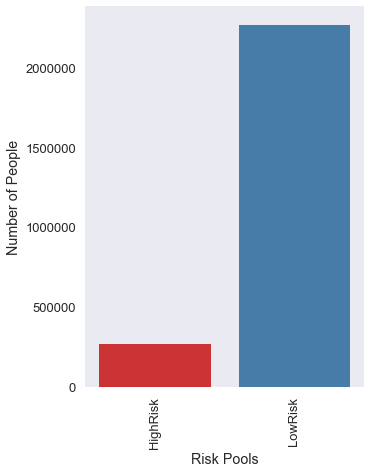

In [37]:
#chart for bigger bar chart
plt.rcParams['figure.figsize'] = 5,7
sns.set_style("darkgrid")
sns.set_context("talk")
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.barplot(y= [high_risktotal, low_risktotal], x = ["HighRisk", "LowRisk"], palette=("Set1"))
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
ax.grid(False)
ax.set(xlabel='Risk Pools', ylabel='Number of People')
       #title = 'Leading Causes of Death in Chicago in 2013
plt.xticks(rotation=90)
plt.rcParams['savefig.dpi'] = 200
plt.show()

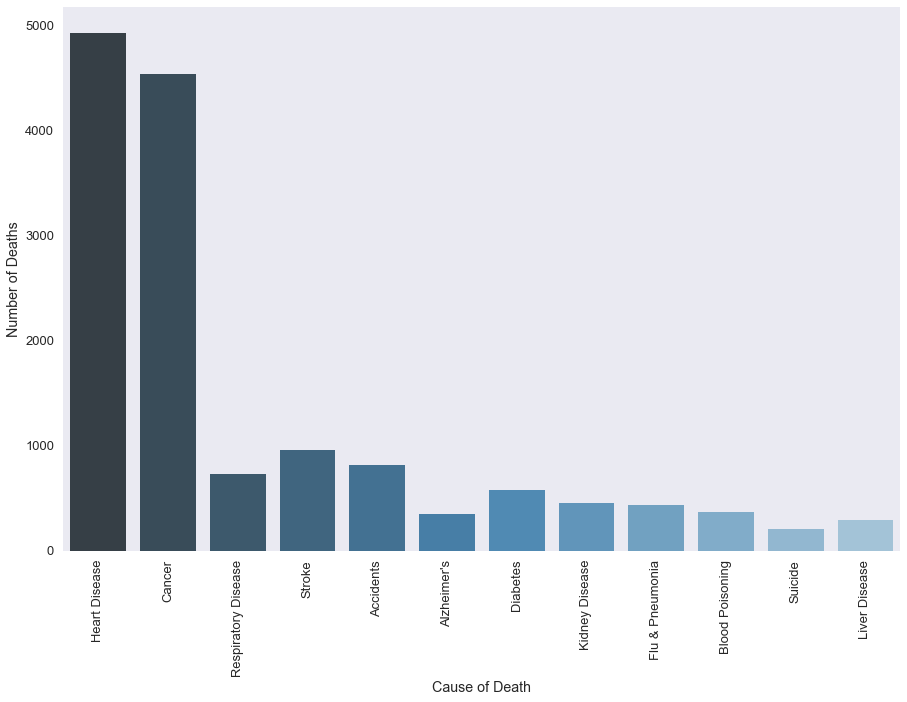

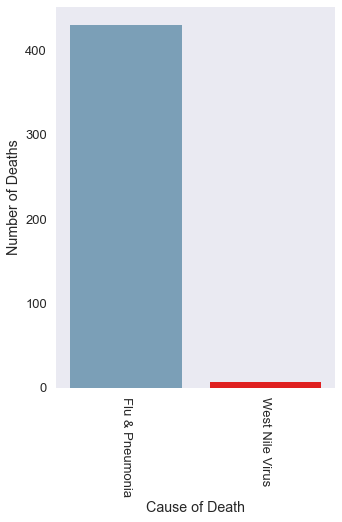

In [38]:
import pandas as pd

#data for bigger bar chart showing leading causese of death

deaths = [4927, 4536, 731, 957, 819, 351, 572, 449, 430, 366, 206, 294]
colsquick = ['Heart Disease',
       'Cancer', 'Respiratory Disease',
       'Stroke','Accidents', 'Alzheimer\'s','Diabetes',
       'Kidney Disease','Flu & Pneumonia',
       'Blood Poisoning', 'Suicide', 'Liver Disease']
#data for smaller just comparing flue versus wnv
colalt = ['Flu & Pneumonia', 'West Nile Virus']
deathalt = [430,7]

#chart for bigger bar chart
plt.rcParams['figure.figsize'] = 15,10
sns.set_style("darkgrid")
sns.set_context("talk")
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.barplot(y= deaths, x = colsquick, palette=("Blues_d"))
ax.grid(False)
ax.set(xlabel='Cause of Death', ylabel='Number of Deaths', 
       #title = 'Leading Causes of Death in Chicago in 2013'
      )
plt.xticks(rotation=90)
plt.rcParams['savefig.dpi'] = 200
plt.show()

#chart for smaller bar chart
plt.rcParams['figure.figsize'] = 5,7
plt.xticks(rotation=-90)
ax = sns.barplot(y= deathalt, x = colalt, palette=["#71A1C1", "red"])
ax.grid(False)
ax.set(xlabel='Cause of Death', ylabel='Number of Deaths',)
plt.rcParams['savefig.dpi'] = 200
plt.show()

In [39]:
sightings.groupby(["Longitude", "Latitude"], as_index=False)["WnvPresent"].sum().sort_values("WnvPresent", ascending= False)

,Longitude,Latitude,WnvPresent
0,-87.890615,41.974689,46
19,-87.731435,41.743402,8
5,-87.800991,41.954690,8
7,-87.785288,41.923738,8
25,-87.716788,41.899230,8
49,-87.627096,41.776428,7
3,-87.807277,42.009876,7
12,-87.757639,41.964242,7
48,-87.632085,41.921965,6
34,-87.689778,41.986921,6


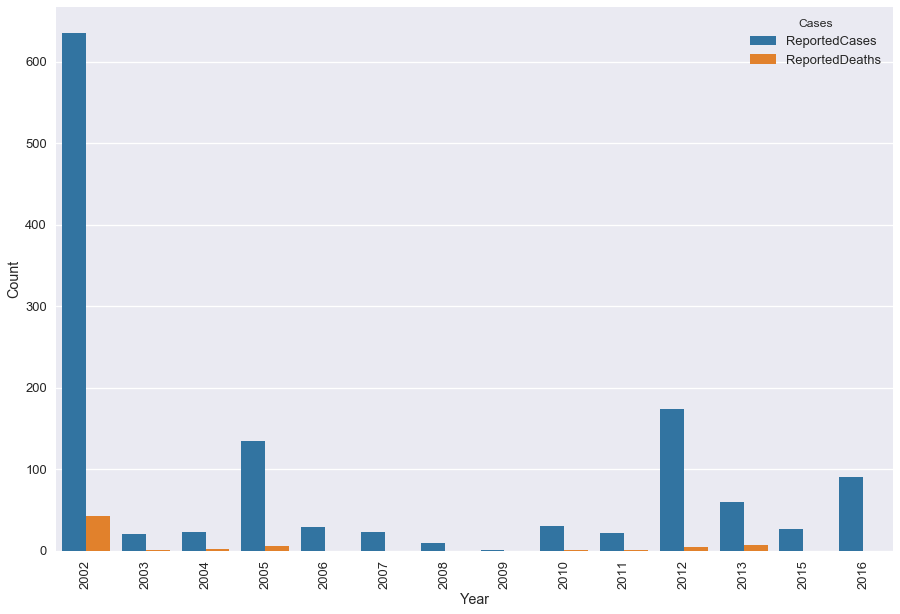

In [41]:
wnv_years = []
for i in range(2002,2017):
    wnv_years.append(str(i))
wnv_cases = [635, 20, 23, 135, 29, 23, 9, 1, 30, 22, 174, 60, None, 27, 90]
wnv_deaths = [42, 1, 2, 6, None, 0, 0, 0, 1, 1, 5, 7, None, 0, 0]

wnv_casedeaths = pd.DataFrame({"Year": wnv_years, "ReportedCases": wnv_cases, "ReportedDeaths" : wnv_deaths})

wnv_cases = pd.melt(wnv_casedeaths, id_vars="Year", var_name="Cases", value_name="Count")
wnv_cases = wnv_cases.dropna()

plt.rcParams['figure.figsize'] = 15,10
plt.xticks(rotation=90)
sns.barplot(x = "Year", y = "Count", data = wnv_cases, hue = "Cases")
plt.show()